##Data Preprocessing

**Install Dependencies**

In [1]:
!pip install emoji
!pip install transformers
!pip install tqdm

^C
ERROR: Operation cancelled by user


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('./drive/MyDrive/Neural_Network_HW')

**Import Dependencies**

In [2]:
import pandas as pd
import emoji
import torch
from transformers import BertTokenizer, BertModel
from torch.optim import Adam
from torch.nn import BCELoss
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss

**Load Dataset**

In [3]:
# Import the datasets using pandas.
test_path = '/kaggle/input/pretraindbertdataset/Train.csv'
train_path = '/kaggle/input/pretraindbertdataset/Train.csv'
validation_path = '/kaggle/input/pretraindbertdataset/Val.csv'

test_data = pd.read_csv(test_path,index_col='id')
train_data = pd.read_csv(train_path,index_col='id')
validation_data = pd.read_csv(validation_path,index_col='id')

In [4]:
# Check for null values in each dataset.
null_counts = {
    'test': test_data.isnull().sum(),
    'train': train_data.isnull().sum(),
    'validation': validation_data.isnull().sum()
}

for dataset_name, null_count in null_counts.items():
    print(f"{dataset_name} dataset null value counts:")
    print(null_count)


test dataset null value counts:
tweet    0
label    0
dtype: int64
train dataset null value counts:
tweet    0
label    0
dtype: int64
validation dataset null value counts:
tweet    0
label    0
dtype: int64


**Replace emojis with text**

In [5]:
# Function to replace emojis with text
def replace_emojis(text):
    return emoji.demojize(text, delimiters=("", ""))

test_data['tweet_with_text_emojis'] = test_data['tweet'].apply(replace_emojis)
train_data['tweet_with_text_emojis'] = train_data['tweet'].apply(replace_emojis)
validation_data['tweet_with_text_emojis'] = validation_data['tweet'].apply(replace_emojis)


In [6]:
#Print one sample of replacing emojies
test_data[34:35]

,tweet,label,tweet_with_text_emojis
id,,,
35,Singapore Airlines Haults All Flights Due To C...,fake,Singapore Airlines Haults All Flights Due To C...


**Binary Label Encoding**

In [7]:
label_mapping = {'real': 1, 'fake': 0}
train_labels = torch.tensor(train_data['label'].map(label_mapping).values)
validation_labels = torch.tensor(validation_data['label'].map(label_mapping).values)
test_labels = torch.tensor(test_data['label'].map(label_mapping).values)

**Tokenization for BERT: Transforming Text into Input Features**

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_tokenized = tokenizer(train_data['tweet_with_text_emojis'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
validation_tokenized = tokenizer(validation_data['tweet_with_text_emojis'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
test_tokenized = tokenizer(test_data['tweet_with_text_emojis'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)

**Utilizing GPU**

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Performance Evaluation and Visualization Functions

In [11]:
def plot_metrics(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'r', label='Training loss')
    plt.plot(val_losses[:, 0], val_losses[:, 1], 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies[:, 0], val_accuracies[:, 1], 'b', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [12]:
def display_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [13]:
def eval_model_mlp(model, validation_dataloader):
    loss = 0
    model.eval()
    with torch.no_grad():
        preds = []
        labels = []
        for val_batch in validation_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = val_batch
            batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

            output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            cls_token = output[0][:, 0, :]
            classification_output = torch.sigmoid(clf_layer(cls_token))

            loss += loss_fn(classification_output.squeeze(), batch_labels.float().squeeze()).item()

            preds.extend(torch.round(classification_output.squeeze()).tolist())
            labels.extend(batch_labels.tolist())

        preds = np.array(preds)
        labels = np.array(labels)
        accuracy = np.sum(preds == labels) / len(preds)

    return loss / len(validation_dataloader), accuracy

In [14]:
def eval_model_bigru(model, validation_dataloader):
    loss = 0
    total_test_correct=0
    total_test_samples = 0
    avg_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        preds = []
        labels = []
        for val_batch in validation_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = val_batch
            batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

            output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            classification_output = torch.sigmoid(output)
            preds = torch.round(classification_output)
            total_test_correct += (torch.round(classification_output.squeeze()) == batch_labels).sum().item()
            total_test_samples += batch_labels.size(0)
            avg_test_accuracy = total_test_correct / total_test_samples

            loss += loss_fn(output.squeeze(), batch_labels.float().squeeze()).item()

            # preds.extend(torch.round(output.squeeze()).tolist())
            # labels.extend(batch_labels.tolist())

        # preds = np.array(preds)
        # labels = np.array(labels)
        # accuracy = np.sum(preds == labels) / len(preds)

    return loss / len(validation_dataloader), avg_test_accuracy

#Model Loading

In [15]:
val_accuracy_dic = {}
val_losses_dic = {}
train_losses_dic = {}

**Batch Management with PyTorch DataLoader**

In [17]:
batch_size = 4
num_epochs = 3

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_tokenized.input_ids, train_tokenized.attention_mask, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

validation_dataset = TensorDataset(validation_tokenized.input_ids, validation_tokenized.attention_mask, validation_labels)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

test_dataset = TensorDataset(test_tokenized.input_ids, test_tokenized.attention_mask, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#Implementation of Model (Fine-Tuning Approach)

###BERT

**Model Initialization and Configuration for BERT-based Binary Classification**

In [77]:
model = BertModel.from_pretrained("bert-base-uncased").to(device)
clf_layer = torch.nn.Linear(model.config.hidden_size, 1).to(device)
optimizer = Adam(list(model.parameters()) + list(clf_layer.parameters()), lr=1e-5)
loss_fn = BCELoss()

In [78]:
train_losses = []
val_losses = []
val_accuracies = []

eval_step = 500
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    losses = []
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()

        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        cls_token = output[0][:, 0, :]
        classification_output = torch.sigmoid(clf_layer(cls_token))
        loss = loss_fn(classification_output.squeeze(), batch_labels.float().squeeze())

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (idx!=0 or epoch==0) and idx % eval_step == 0:
            val_loss, val_acc = eval_model_mlp(model, validation_dataloader)
            val_losses.append((epoch*len(train_dataloader)+idx, val_loss))
            val_accuracies.append((epoch*len(train_dataloader)+idx, val_acc))

    if idx % eval_step != 0:
        val_loss, val_acc = eval_model_mlp(model, validation_dataloader)
        val_losses.append(((epoch+1)*len(train_dataloader), val_loss))
        val_accuracies.append(((epoch+1)*len(train_dataloader), val_acc))

    train_losses.extend(np.cumsum(losses) / np.arange(1, len(losses)+1))

Epoch 1/3


1605it [04:00,  6.67it/s]


Epoch 2/3


1605it [03:45,  7.13it/s]


Epoch 3/3


1605it [03:45,  7.12it/s]


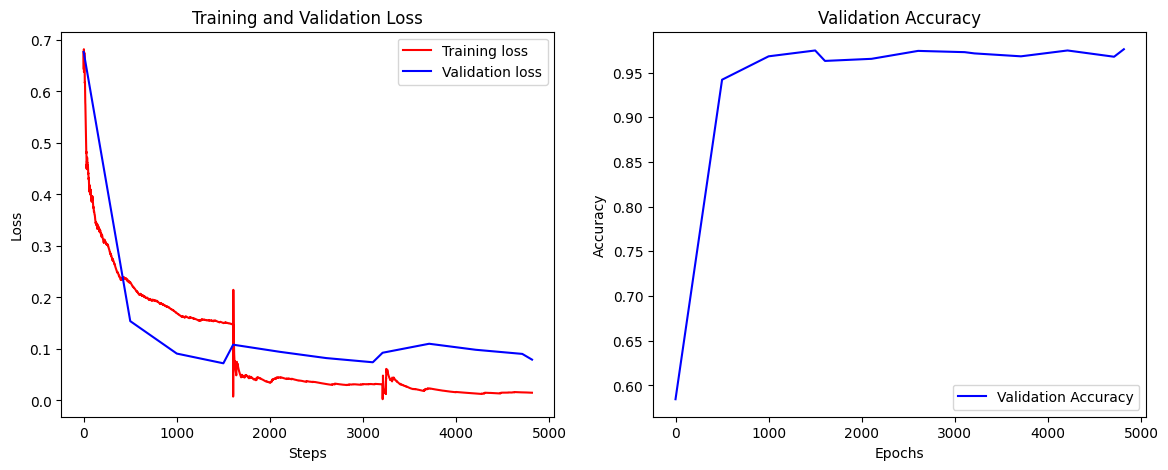

In [79]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_accuracies = np.array(val_accuracies)

train_losses_dic["BERT"] = train_losses
val_losses_dic["BERT"] = val_losses
val_accuracy_dic["BERT"] = val_accuracies
# val_losses_dic["BERT"] = val_losses
plot_metrics(train_losses, val_losses, val_accuracies)

Test Accuracy: 0.9989
Test F1 Score: 0.9990


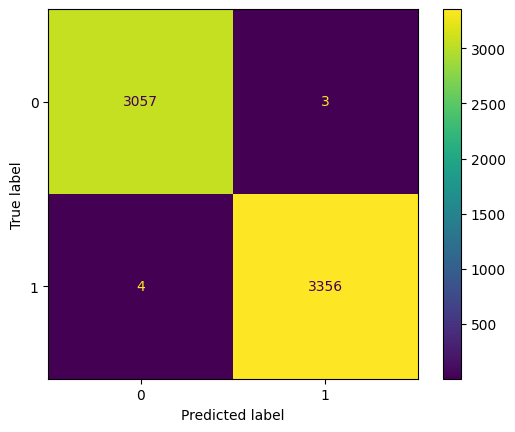

In [83]:
model.eval()
total_test_correct, total_test_samples = 0, 0
all_test_labels, all_test_preds = [], []
wrong_cases = []  # To store wrong cases
max_wrong_cases_to_print = 2
for batch_idx, batch in enumerate(test_dataloader):

    batch_input_ids, batch_attention_mask, batch_labels = batch
    batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

    with torch.no_grad():
        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        cls_token = output[0][:, 0, :]
        classification_output = torch.sigmoid(clf_layer(cls_token))
        preds = torch.round(classification_output)
        
        wrong_indices = (torch.round(classification_output.squeeze()) != batch_labels).nonzero(as_tuple=True)[0]
        for idx in wrong_indices:
            wrong_cases.append({
                'input_ids': batch_input_ids[idx].cpu().numpy(),
                'attention_mask': batch_attention_mask[idx].cpu().numpy(),
                'label': batch_labels[idx].cpu().item(),
                'prediction': preds[idx].cpu().item()
            })
        
        total_test_correct += (torch.round(classification_output.squeeze()) == batch_labels).sum().item()
        total_test_samples += batch_labels.size(0)
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())

avg_test_accuracy = total_test_correct / total_test_samples
print(f"Test Accuracy: {avg_test_accuracy:.4f}")
test_f1 = f1_score(all_test_labels, all_test_preds)
print(f"Test F1 Score: {test_f1:.4f}")


# Confusion Matrix
display_confusion_matrix(all_test_labels, all_test_preds)

###BERTBiGRU

In [22]:
class BERTBiGRUClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_size, num_classes):
        super(BERTBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gru = nn.GRU(input_size=self.bert.config.hidden_size, hidden_size=hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_outputs.last_hidden_state
        gru_output, _ = self.gru(last_hidden_state)
        cls_token = gru_output[:, 0, :]
        output = self.classifier(cls_token)
        # classification_output = torch.sigmoid(output)
        return output


bert_model_name = 'bert-base-uncased'
hidden_size = 128
num_classes = 1
num_epochs = 3
learning_rate = 1e-5

model = BERTBiGRUClassifier(bert_model_name, hidden_size, num_classes).to(device)
loss_fn = BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
train_losses = []
val_losses = []
val_accuracies = []

eval_step = 500
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    losses = []
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

        optimizer.zero_grad()

        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        loss = loss_fn(output.squeeze(), batch_labels.float().squeeze())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (idx!=0 or epoch==0) and idx % eval_step == 0:
            val_loss, val_acc = eval_model_bigru(model, validation_dataloader)
            val_losses.append((epoch*len(train_dataloader)+idx, val_loss))
            val_accuracies.append((epoch*len(train_dataloader)+idx, val_acc))
            model.train()

    if idx % eval_step != 0:
        val_loss, val_acc = eval_model_bigru(model, validation_dataloader)
        val_losses.append(((epoch+1)*len(train_dataloader), val_loss))
        val_accuracies.append(((epoch+1)*len(train_dataloader), val_acc))
        model.train()

    train_losses.extend(np.cumsum(losses) / np.arange(1, len(losses)+1))

Epoch 1/3


1605it [04:09,  6.44it/s]


Epoch 2/3


1605it [03:52,  6.90it/s]


Epoch 3/3


1605it [03:52,  6.91it/s]


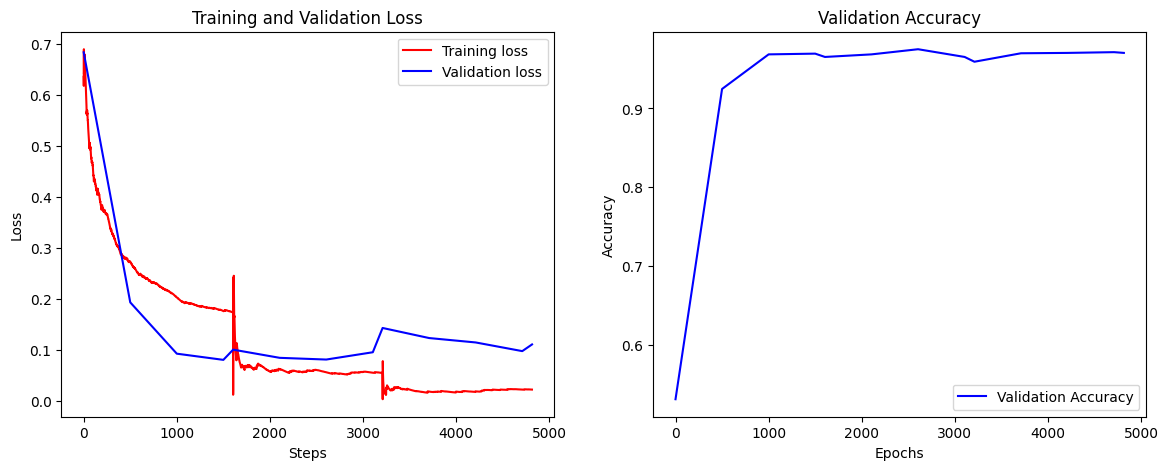

In [24]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_accuracies = np.array(val_accuracies)

train_losses_dic["BERTBiGRUClassifier-ft"] = train_losses
val_losses_dic["BERTBiGRUClassifier-ft"] = val_losses
val_accuracy_dic["BERTBiGRUClassifier-ft"] = val_accuracies

plot_metrics(train_losses, val_losses, val_accuracies)

Test Accuracy: 0.9955
Test F1 Score: 0.9957


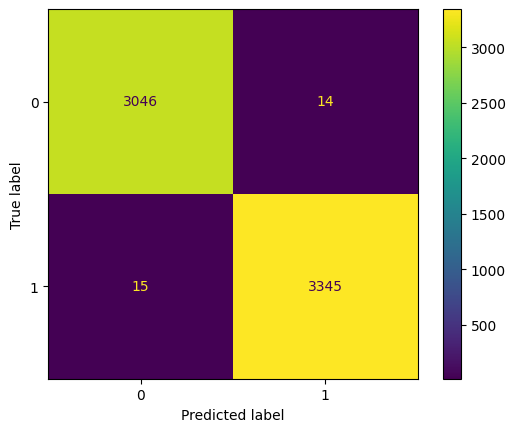

In [26]:
model.eval()
total_test_correct, total_test_samples = 0, 0
all_test_labels, all_test_preds = [], []
for batch_idx, batch in enumerate(test_dataloader):

    batch_input_ids, batch_attention_mask, batch_labels = batch
    batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

    with torch.no_grad():
        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        classification_output = torch.sigmoid(output)
        preds = torch.round(classification_output)
        total_test_correct += (torch.round(classification_output.squeeze()) == batch_labels).sum().item()
        total_test_samples += batch_labels.size(0)
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())

avg_test_accuracy = total_test_correct / total_test_samples
print(f"Test Accuracy: {avg_test_accuracy:.4f}")
test_f1 = f1_score(all_test_labels, all_test_preds)
print(f"Test F1 Score: {test_f1:.4f}")


# Confusion Matrix
display_confusion_matrix(all_test_labels, all_test_preds)

### CT-BERTBiGRU

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer

class BERTBiGRUClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_size, num_classes):
        super(BERTBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gru = nn.GRU(input_size=self.bert.config.hidden_size, hidden_size=hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_outputs.last_hidden_state
        gru_output, _ = self.gru(last_hidden_state)
        cls_token = gru_output[:, 0, :]
        output = self.classifier(cls_token)
        return output


bert_model_name = 'digitalepidemiologylab/covid-twitter-bert'
hidden_size = 128
num_classes = 1
num_epochs = 3
learning_rate = 1e-5

model = BERTBiGRUClassifier(bert_model_name, hidden_size, num_classes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [28]:
train_losses = []
val_losses = []
val_accuracies = []

eval_step = 500
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    losses = []
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

        optimizer.zero_grad()

        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        loss = loss_fn(output.squeeze(), batch_labels.float().squeeze())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (idx!=0 or epoch==0) and idx % eval_step == 0:
            val_loss, val_acc = eval_model_bigru(model, validation_dataloader)
            val_losses.append((epoch*len(train_dataloader)+idx, val_loss))
            val_accuracies.append((epoch*len(train_dataloader)+idx, val_acc))
            model.train()

    if idx % eval_step != 0:
        val_loss, val_acc = eval_model_bigru(model, validation_dataloader)
        val_losses.append(((epoch+1)*len(train_dataloader), val_loss))
        val_accuracies.append(((epoch+1)*len(train_dataloader), val_acc))
        model.train()

    train_losses.extend(np.cumsum(losses) / np.arange(1, len(losses)+1))

Epoch 1/3


1605it [14:08,  1.89it/s]


Epoch 2/3


1605it [13:12,  2.03it/s]


Epoch 3/3


1605it [13:12,  2.03it/s]


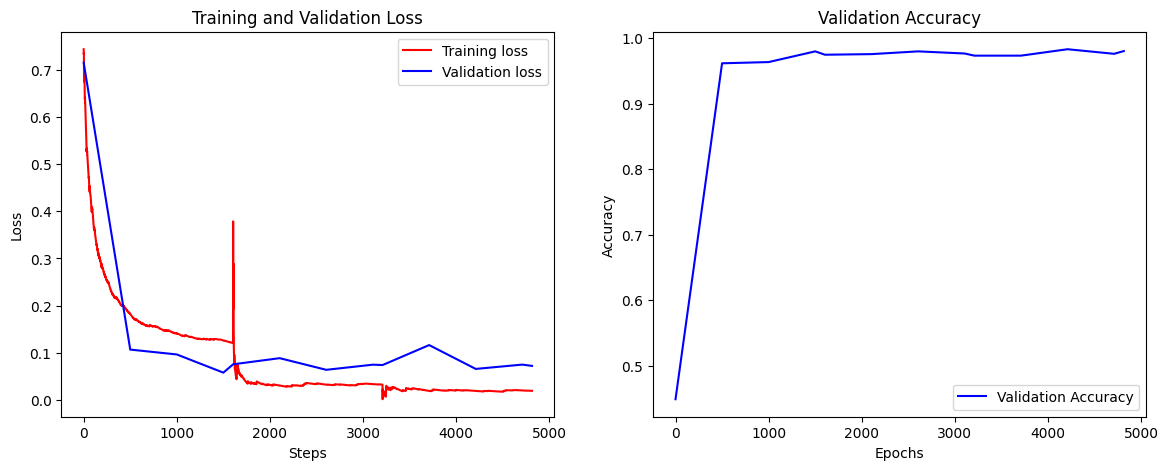

In [29]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_accuracies = np.array(val_accuracies)

train_losses_dic["CT-BERTBiGRU-ft"] = train_losses
val_losses_dic["CT-BERTBiGRU-ft"] = val_losses
val_accuracy_dic["CT-BERTBiGRU-ft"] = val_accuracies

plot_metrics(train_losses, val_losses, val_accuracies)

Test Accuracy: 0.9988
Test F1 Score: 0.9988


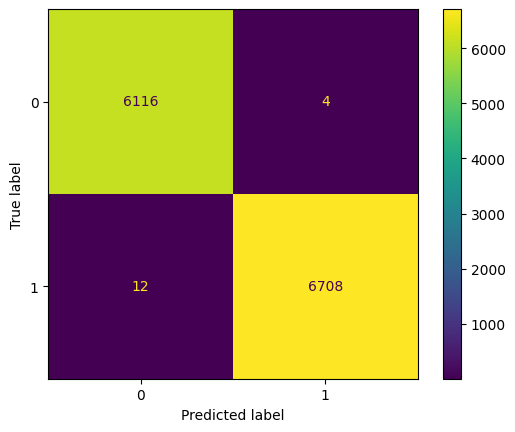

In [30]:
model.eval()
total_test_correct, total_test_samples = 0, 0
all_test_labels, all_test_preds = [], []
for batch_idx, batch in enumerate(test_dataloader):

    batch_input_ids, batch_attention_mask, batch_labels = batch
    batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

    with torch.no_grad():
        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        classification_output = torch.sigmoid(output)
        preds = torch.round(classification_output)
        total_test_correct += (torch.round(classification_output.squeeze()) == batch_labels).sum().item()
        total_test_samples += batch_labels.size(0)
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())

avg_test_accuracy = total_test_correct / total_test_samples
print(f"Test Accuracy: {avg_test_accuracy:.4f}")
test_f1 = f1_score(all_test_labels, all_test_preds)
print(f"Test F1 Score: {test_f1:.4f}")


# Confusion Matrix
display_confusion_matrix(all_test_labels, all_test_preds)

#Implementation of Model (Feature-Based)

###Bert

In [66]:
train_losses = []
val_losses = []
val_accuracies = []

model = BertModel.from_pretrained("bert-base-uncased").to(device)
for param in model.parameters():
    param.requires_grad = False
    
clf_layer = torch.nn.Linear(model.config.hidden_size, 1).to(device)
optimizer = Adam(clf_layer.parameters(), lr=1e-5)
loss_fn = BCELoss()

eval_step = 500
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    losses = []
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

        optimizer.zero_grad()

        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        cls_token = output[0][:, 0, :]
        classification_output = torch.sigmoid(clf_layer(cls_token))

        loss = loss_fn(classification_output.squeeze(), batch_labels.float().squeeze())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (idx!=0 or epoch==0) and idx % eval_step == 0:
            val_loss, val_acc = eval_model_mlp(model, validation_dataloader)
            val_losses.append((epoch*len(train_dataloader)+idx, val_loss))
            val_accuracies.append((epoch*len(train_dataloader)+idx, val_acc))

    if idx % eval_step != 0:
        val_loss, val_acc = eval_model_mlp(model, validation_dataloader)
        val_losses.append(((epoch+1)*len(train_dataloader), val_loss))
        val_accuracies.append(((epoch+1)*len(train_dataloader), val_acc))

    train_losses.extend(np.cumsum(losses) / np.arange(1, len(losses)+1))

Epoch 1/3


1605it [01:51, 14.35it/s]


Epoch 2/3


1605it [01:35, 16.75it/s]


Epoch 3/3


1605it [01:35, 16.77it/s]


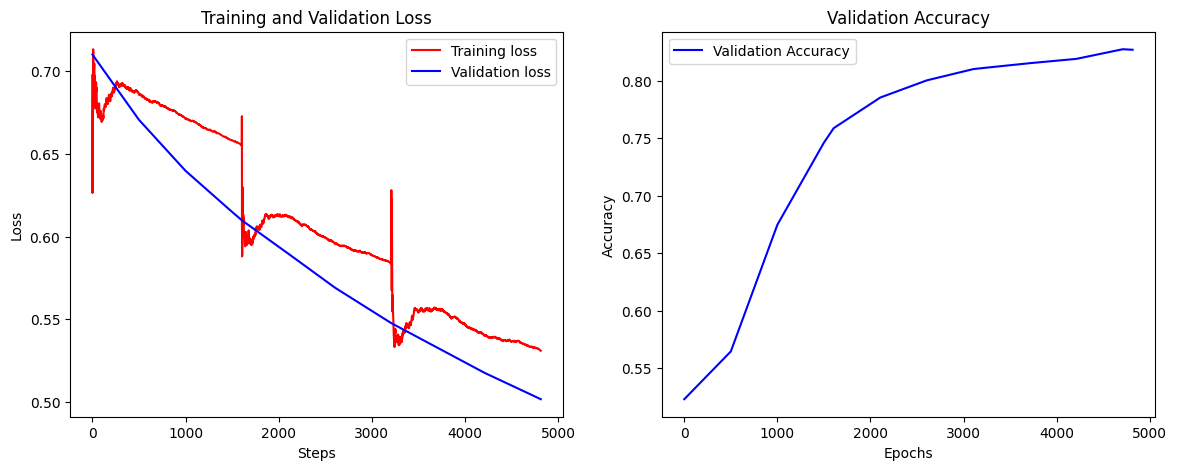

In [67]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_accuracies = np.array(val_accuracies)

train_losses_dic["BERT-fb"] = train_losses
val_losses_dic["BERT-fb"] = val_losses
val_accuracy_dic["BERT-fb"] = val_accuracies

plot_metrics(train_losses, val_losses, val_accuracies)

Test Accuracy: 0.8181
Test F1 Score: 0.8443


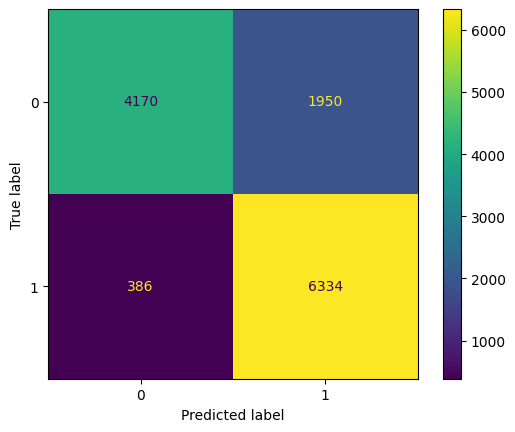

In [68]:
model.eval()
total_test_correct, total_test_samples = 0, 0
all_test_labels, all_test_preds = [], []
for batch_idx, batch in enumerate(test_dataloader):

    batch_input_ids, batch_attention_mask, batch_labels = batch
    batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

    with torch.no_grad():
        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        cls_token = output[0][:, 0, :]
        classification_output = torch.sigmoid(clf_layer(cls_token))
        preds = torch.round(classification_output)
        total_test_correct += (torch.round(classification_output.squeeze()) == batch_labels).sum().item()
        total_test_samples += batch_labels.size(0)
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())

avg_test_accuracy = total_test_correct / total_test_samples
print(f"Test Accuracy: {avg_test_accuracy:.4f}")
test_f1 = f1_score(all_test_labels, all_test_preds)
print(f"Test F1 Score: {test_f1:.4f}")


# Confusion Matrix
display_confusion_matrix(all_test_labels, all_test_preds)

###CT-BERTBiGRU

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer

class BERTBiGRUClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_size, num_classes):
        super(BERTBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gru = nn.GRU(input_size=self.bert.config.hidden_size, hidden_size=hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_outputs.last_hidden_state
        gru_output, _ = self.gru(last_hidden_state)
        cls_token = gru_output[:, 0, :]
        output = self.classifier(cls_token)
        return output


bert_model_name = 'digitalepidemiologylab/covid-twitter-bert'
hidden_size = 128
num_classes = 1
num_epochs = 3
learning_rate = 1e-5

model = BERTBiGRUClassifier(bert_model_name, hidden_size, num_classes).to(device)
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)


In [52]:
train_losses = []
val_losses = []
val_accuracies = []

eval_step = 500
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    losses = []
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

        optimizer.zero_grad()

        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        loss = loss_fn(output.squeeze(), batch_labels.float().squeeze())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (idx!=0 or epoch==0) and idx % eval_step == 0:
            val_loss, val_acc = eval_model_bigru(model, validation_dataloader)
            val_losses.append((epoch*len(train_dataloader)+idx, val_loss))
            val_accuracies.append((epoch*len(train_dataloader)+idx, val_acc))
            model.train()

    if idx % eval_step != 0:
        val_loss, val_acc = eval_model_bigru(model, validation_dataloader)
        val_losses.append(((epoch+1)*len(train_dataloader), val_loss))
        val_accuracies.append(((epoch+1)*len(train_dataloader), val_acc))
        model.train()

    train_losses.extend(np.cumsum(losses) / np.arange(1, len(losses)+1))

Epoch 1/3


1605it [06:31,  4.10it/s]


Epoch 2/3


1605it [05:35,  4.79it/s]


Epoch 3/3


1605it [05:35,  4.78it/s]


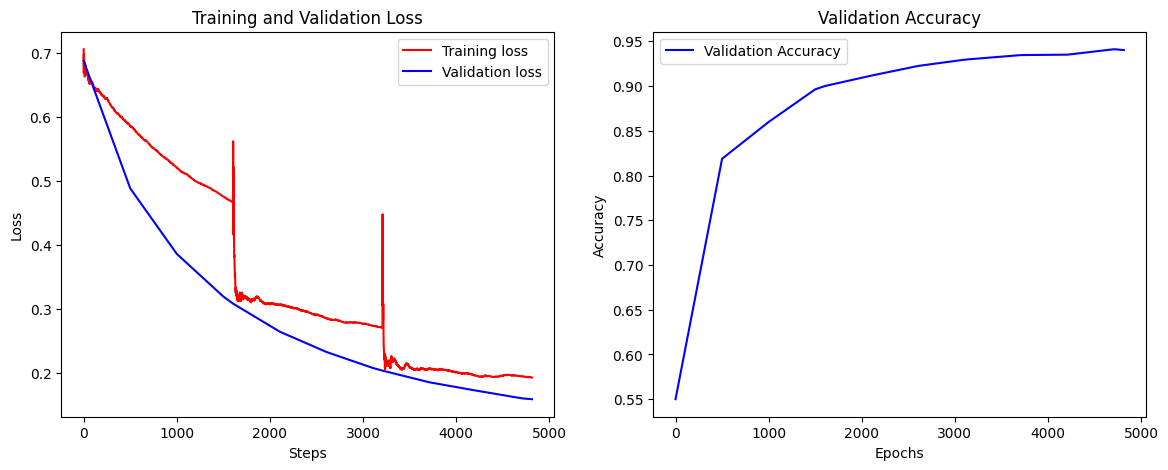

In [53]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_accuracies = np.array(val_accuracies)

train_losses_dic["CT-BERTBiGRU-fb"] = train_losses
val_losses_dic["CT-BERTBiGRU-fb"] = val_losses
val_accuracy_dic["CT-BERTBiGRU-fb"] = val_accuracies

plot_metrics(train_losses, val_losses, val_accuracies)

Test Accuracy: 0.9484
Test F1 Score: 0.9515


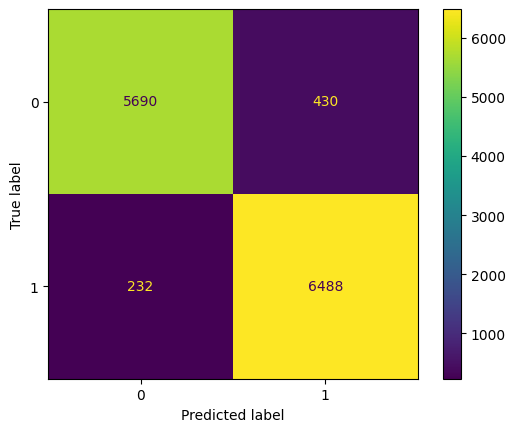

In [54]:
model.eval()
total_test_correct, total_test_samples = 0, 0
all_test_labels, all_test_preds = [], []
for batch_idx, batch in enumerate(test_dataloader):

    batch_input_ids, batch_attention_mask, batch_labels = batch
    batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

    with torch.no_grad():
        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        classification_output = torch.sigmoid(output)
        preds = torch.round(classification_output)
        total_test_correct += (torch.round(classification_output.squeeze()) == batch_labels).sum().item()
        total_test_samples += batch_labels.size(0)
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())

avg_test_accuracy = total_test_correct / total_test_samples
print(f"Test Accuracy: {avg_test_accuracy:.4f}")
test_f1 = f1_score(all_test_labels, all_test_preds)
print(f"Test F1 Score: {test_f1:.4f}")


# Confusion Matrix
display_confusion_matrix(all_test_labels, all_test_preds)

###BERTBiGRU

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer

class BERTBiGRUClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_size, num_classes):
        super(BERTBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gru = nn.GRU(input_size=self.bert.config.hidden_size, hidden_size=hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_outputs.last_hidden_state
        gru_output, _ = self.gru(last_hidden_state)
        cls_token = gru_output[:, 0, :]
        output = self.classifier(cls_token)
        return output


bert_model_name = 'bert-base-uncased'
hidden_size = 128
num_classes = 1
num_epochs = 3
learning_rate = 1e-5

model = BERTBiGRUClassifier(bert_model_name, hidden_size, num_classes).to(device)
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)

In [44]:
train_losses = []
val_losses = []
val_accuracies = []

eval_step = 500
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    losses = []
    model.train()
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

        optimizer.zero_grad()

        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        loss = loss_fn(output.squeeze(), batch_labels.float().squeeze())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (idx!=0 or epoch==0) and idx % eval_step == 0:
            val_loss, val_acc = eval_model_bigru(model, validation_dataloader)
            val_losses.append((epoch*len(train_dataloader)+idx, val_loss))
            val_accuracies.append((epoch*len(train_dataloader)+idx, val_acc))
            model.train()

    if idx % eval_step != 0:
        val_loss, val_acc = eval_model_bigru(model, validation_dataloader)
        val_losses.append(((epoch+1)*len(train_dataloader), val_loss))
        val_accuracies.append(((epoch+1)*len(train_dataloader), val_acc))
        model.train()

    train_losses.extend(np.cumsum(losses) / np.arange(1, len(losses)+1))

Epoch 1/3


1605it [01:51, 14.38it/s]


Epoch 2/3


1605it [01:35, 16.78it/s]


Epoch 3/3


1605it [01:35, 16.81it/s]


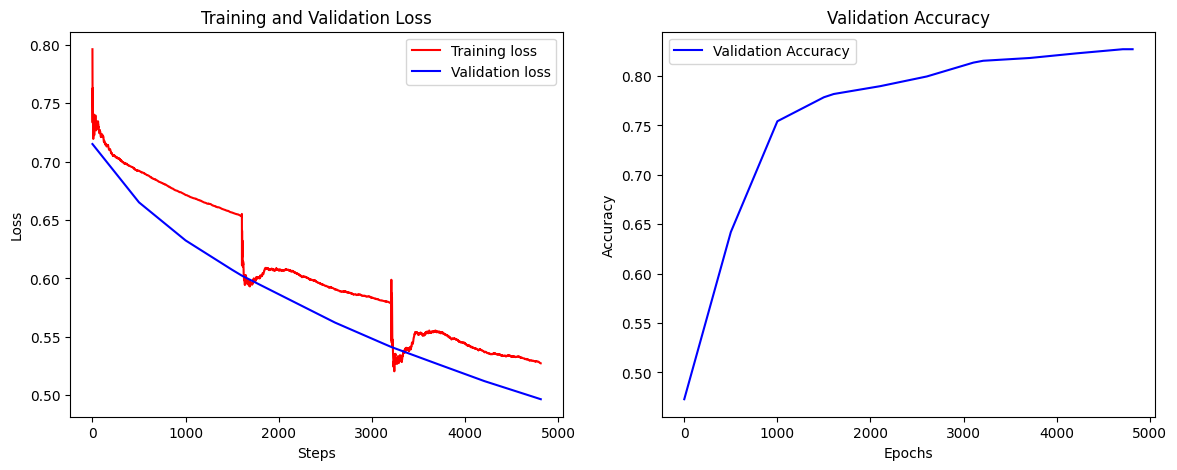

In [45]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_accuracies = np.array(val_accuracies)

train_losses_dic["BERTBiGRU-fb"] = train_losses
val_losses_dic["BERTBiGRU-fb"] = val_losses
val_accuracy_dic["BERTBiGRU-fb"] = val_accuracies

plot_metrics(train_losses, val_losses, val_accuracies)

Test Accuracy: 0.8254
Test F1 Score: 0.8494


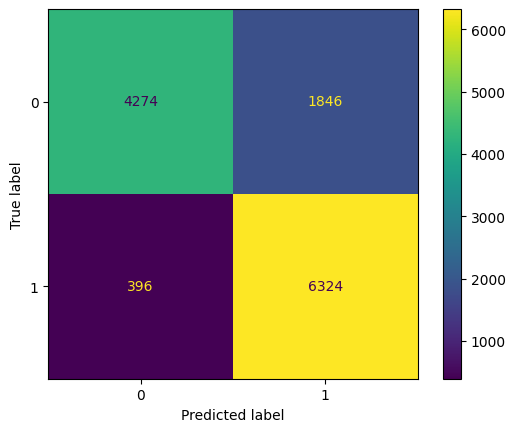

In [46]:
model.eval()
total_test_correct, total_test_samples = 0, 0
all_test_labels, all_test_preds = [], []
for batch_idx, batch in enumerate(test_dataloader):

    batch_input_ids, batch_attention_mask, batch_labels = batch
    batch_input_ids, batch_attention_mask, batch_labels = batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels.to(device)

    with torch.no_grad():
        output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        cls_token = output[0][:, 0, :]
        classification_output = torch.sigmoid(clf_layer(cls_token))
        preds = torch.round(classification_output)
        total_test_correct += (torch.round(classification_output.squeeze()) == batch_labels).sum().item()
        total_test_samples += batch_labels.size(0)
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(batch_labels.cpu().detach().numpy())
        all_test_preds.extend(preds.cpu().numpy())

avg_test_accuracy = total_test_correct / total_test_samples
print(f"Test Accuracy: {avg_test_accuracy:.4f}")
test_f1 = f1_score(all_test_labels, all_test_preds)
print(f"Test F1 Score: {test_f1:.4f}")


# Confusion Matrix
display_confusion_matrix(all_test_labels, all_test_preds)

In [65]:
# train_losses_dic["BERT"] = train_losses
# val_losses_dic["BERT"] = val_losses
# val_accuracy_dic.keys()
train_losses_dic.keys()
# val_losses_dic.keys()

dict_keys(['BERT', 'BERTBiGRUClassifier-ft', 'CT-BERTBiGRU-ft', 'BERT-fb', 'CT-BERTBiGRU-fb', 'BERTBiGRU-fb'])

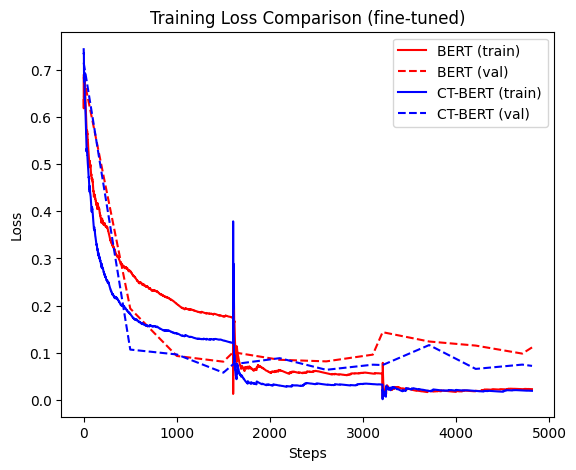

In [74]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_dic["BERTBiGRUClassifier-ft"], 'r', label='BERT (train)')
plt.plot(val_losses_dic["BERTBiGRUClassifier-ft"][:, 0], val_losses_dic["BERTBiGRUClassifier-ft"][:, 1], 'r--', label='BERT (val)')
plt.plot(train_losses_dic["CT-BERTBiGRU-ft"], 'b', label='CT-BERT (train)')
plt.plot(val_losses_dic["CT-BERTBiGRU-ft"][:, 0], val_losses_dic["CT-BERTBiGRU-ft"][:, 1], 'b--', label='CT-BERT (val)')
plt.title('Training Loss Comparison (fine-tuned)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()


<Figure size 1400x500 with 0 Axes>

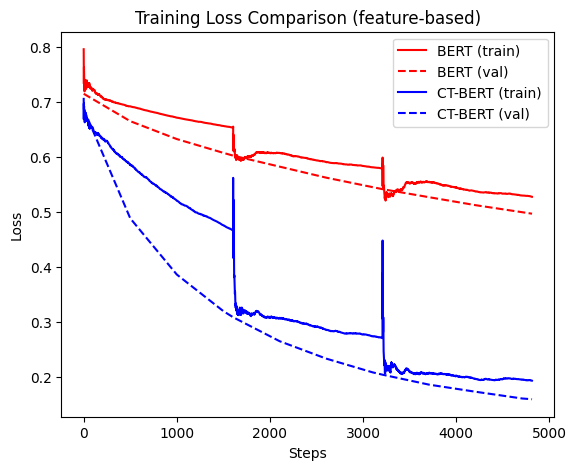

In [75]:
plt.figure(figsize=(14, 5))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_dic["BERTBiGRU-fb"], 'r', label='BERT (train)')
plt.plot(val_losses_dic["BERTBiGRU-fb"][:, 0], val_losses_dic["BERTBiGRU-fb"][:, 1], 'r--', label='BERT (val)')
plt.plot(train_losses_dic["CT-BERTBiGRU-fb"], 'b', label='CT-BERT (train)')
plt.plot(val_losses_dic["CT-BERTBiGRU-fb"][:, 0], val_losses_dic["CT-BERTBiGRU-fb"][:, 1], 'b--', label='CT-BERT (val)')
plt.title('Training Loss Comparison (feature-based)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()


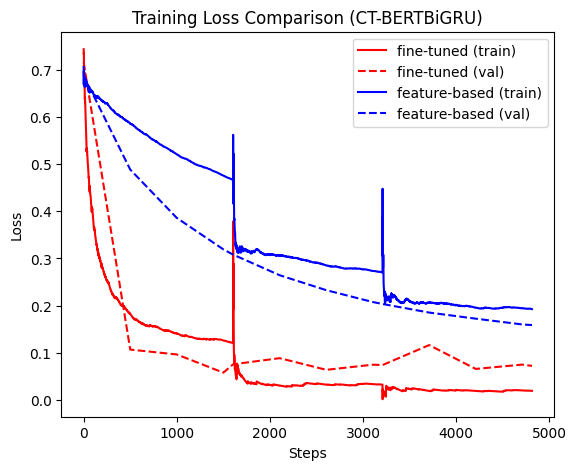

In [76]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_dic["CT-BERTBiGRU-ft"], 'r', label='fine-tuned (train)')
plt.plot(val_losses_dic["CT-BERTBiGRU-ft"][:, 0], val_losses_dic["CT-BERTBiGRU-ft"][:, 1], 'r--', label='fine-tuned (val)')
plt.plot(train_losses_dic["CT-BERTBiGRU-fb"], 'b', label='feature-based (train)')
plt.plot(val_losses_dic["CT-BERTBiGRU-fb"][:, 0], val_losses_dic["CT-BERTBiGRU-fb"][:, 1], 'b--', label='feature-based (val)')
plt.title('Training Loss Comparison (CT-BERTBiGRU)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()


In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_dic["BERT"], 'r', label='fine-tuned (train)')
plt.plot(val_losses_dic["BERT"][:, 0], val_losses_dic["BERT"][:, 1], 'r--', label='BERT (val)')
plt.plot(train_losses_dic["BERTBiGRUClassifier-ft"], 'b', label='BERTBiGRUClassifier-ft (train)')
plt.plot(val_losses_dic["BERTBiGRUClassifier-ft"][:, 0], val_losses_dic["BERTBiGRUClassifier-ft"][:, 1], 'b--', label='feature-based (val)')
plt.plot(train_losses_dic["CT-BERTBiGRU-ft"], 'g', label='CT-BERTBiGRU-ft (train)')
plt.plot(val_losses_dic["CT-BERTBiGRU-ft"][:, 0], val_losses_dic["CT-BERTBiGRU-ft"][:, 1], 'g--', label='feature-based (val)')
plt.title('Training Loss Comparison (fine-tuned)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
